In [450]:
import sys
import json
import pandas as pd
import numpy as np
import itertools
import glob, os
from biom.table import Table

sys.path.append('../')

from src.etl import *
from src.eda import *
from src.graph import *
from src.sparsify import *

In [452]:
# t2d config
disease = 't2d'
otu_table_fp = '../data/t2d/otu_table.csv'
metadata_fp = '../data/t2d/metadata.csv'
rare_otu_threshold = 1
transformation = 'norm'
disease_col = 'IRIS'

In [454]:
otu_table = pd.read_csv(otu_table_fp, index_col=0)
filtered_otu_table = filter_rare_otus(otu_table, rare_otu_threshold)
metadata = pd.read_csv(metadata_fp, index_col=0)

merged = pd.concat([metadata, filtered_otu_table], axis=1)
healthy = merged[merged[disease_col] == 0] #.drop(columns=[disease_col])
diseased = merged[merged[disease_col] == 1] #.drop(columns=[disease_col])

In [456]:
# T2D microbe-outcome
data_loglasso = prune_lasso(merged, metadata, f'../data/{disease}/lasso_covariates_{transformation}.txt')
print(data_loglasso.shape)
t2d_causal_graph = run_cdnod(data_loglasso, disease, f'/{disease}/cdnod_{transformation}')

The pruned dataset has the following dimensions:  (331, 27)
(331, 27)


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

The following genera are directly linked to the 'IRIS' node: 
 genus_Butyricimonas
genus_Clostridium.XlVb
genus_Odoribacter
genus_unclassified_Bacteria
genus_unclassified_Firmicutes
The following genera are directly linked to the 'Gender' node: 
 genus_Erysipelotrichaceae_incertae_sedis
The following genera are directly linked to the 'Ethnicity' node: 
 genus_Butyricicoccus
genus_Coprococcus
genus_Erysipelotrichaceae_incertae_sedis
genus_unclassified_Bacteria


In [458]:
proxy_labels = list(data_loglasso.columns)

In [354]:
proxy_labels.index('genus_Clostridium.XlVa')

10

In [20]:
#To keep ['Butyricimonas', 'Odoribacter', 'Clostridium XIVb']

In [460]:
adj_mat = t2d_causal_graph.graph
adj_mat

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1, -1,
         0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],


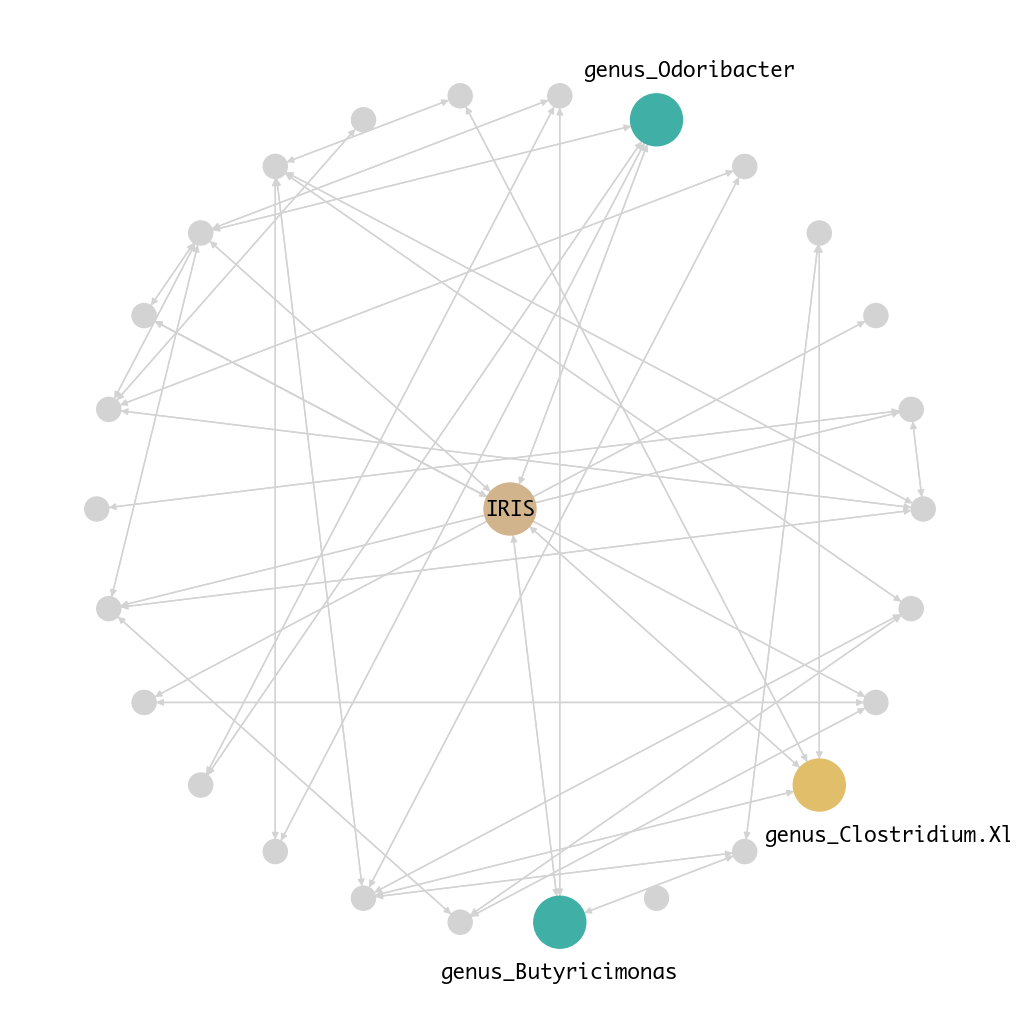

In [358]:
white_ = [0]
teal_ = [8, 19]
yellow_ = [11]

G = nx.from_numpy_array(np.array(adj_mat), create_using=nx.DiGraph)
all_nodes = list(G.nodes)


node_colors = ['lightgray'] * len(G.nodes)
node_sizes = [300] * len(G.nodes)

for idx in white_:
    node_colors[idx] = '#D2B48C'
    node_sizes[idx] = 1400

for idx in teal_:
    node_colors[idx] = '#40B0A6'
    node_sizes[idx] = 1400

for idx in yellow_:
    node_colors[idx] = '#E1BE6A'
    node_sizes[idx] = 1400


shell_layout = [[0]]
other_nodes = [n for n in range(1, len(G.nodes))]
shell_layout.append(other_nodes)


plt.figure(figsize=(10, 10))
pos = nx.shell_layout(G, nlist=shell_layout)

nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=node_sizes, edge_color='lightgray', arrows=True)

labels = {}
for idx in white_:
    labels[idx] = proxy_labels[idx]
for idx in teal_:
    labels[idx] = proxy_labels[idx]
for idx in yellow_:
    labels[idx] = proxy_labels[idx]

label_pos = pos.copy()
label_pos[yellow_[0]] = (label_pos[yellow_[0]][0] + 0.1, label_pos[yellow_[0]][1] - 0.06)
label_pos[teal_[0]] = (label_pos[teal_[0]][0], label_pos[teal_[0]][1] - 0.06)
label_pos[teal_[1]] = (label_pos[teal_[1]][0] + 0.04, label_pos[teal_[1]][1] + 0.06)


nx.draw_networkx_labels(G, label_pos, labels=labels, font_color='black', font_family="monaco", font_size=15)

plt.axis('off')
plt.show()

In [464]:
#pcos config
disease = 'pcos'
otu_table_fp = '../data/pcos/otu_table.csv'
metadata_fp = '../data/pcos/metadata.csv'
rare_otu_threshold = 1
transformation = 'norm'
disease_col = 'group'

In [466]:
otu_table = pd.read_csv(otu_table_fp, index_col=0)
filtered_otu_table = filter_rare_otus(otu_table, rare_otu_threshold)
metadata = pd.read_csv(metadata_fp, index_col=0)

merged = pd.concat([metadata, filtered_otu_table], axis=1)
healthy = merged[merged[disease_col] == 0] #.drop(columns=[disease_col])
diseased = merged[merged[disease_col] == 1] #.drop(columns=[disease_col])

In [468]:
#pcos-outcome network
data_loglasso = prune_lasso(merged, metadata, f'../data/{disease}/lasso_covariates_{transformation}.txt')
print(data_loglasso.shape)
t2d_causal_graph = run_cdnod(data_loglasso, disease, f'/{disease}/cdnod_{transformation}')

The pruned dataset has the following dimensions:  (948, 32)
(948, 32)


  0%|          | 0/32 [00:00<?, ?it/s]

The following genera are directly linked to the 'group' node: 
 Alistipes
Blautia
Burkholderia
Desulfovibrio
Holdemanella
Knoellia
Prevotellaceae_NK3B31_group
Ruminococcus
Ruminococcus_gnavus_group
The following genera are directly linked to the 'region' node: 
 study_site
Alistipes
Allisonella
Blautia
Christensenellaceae_R-7_group
Desulfovibrio
Holdemanella
Succinivibrio
Tyzzerella
UCG-002
The following genera are directly linked to the 'study_site' node: 
 region
Agathobaculum
Corynebacterium
Ruminococcus_gnavus_group


In [470]:
proxy_labels = list(data_loglasso.columns)

In [472]:
proxy_labels.index('Ruminococcus_gnavus_group')

24

In [474]:
adj_mat = t2d_causal_graph.graph
adj_mat

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  1, ..., -1,  0,  0],
       [ 0, -1,  0, ...,  0,  0,  0],
       ...,
       [ 0,  1,  0, ...,  0,  1,  1],
       [ 0,  0,  0, ..., -1,  0,  0],
       [ 0,  0,  0, ..., -1,  0,  0]])

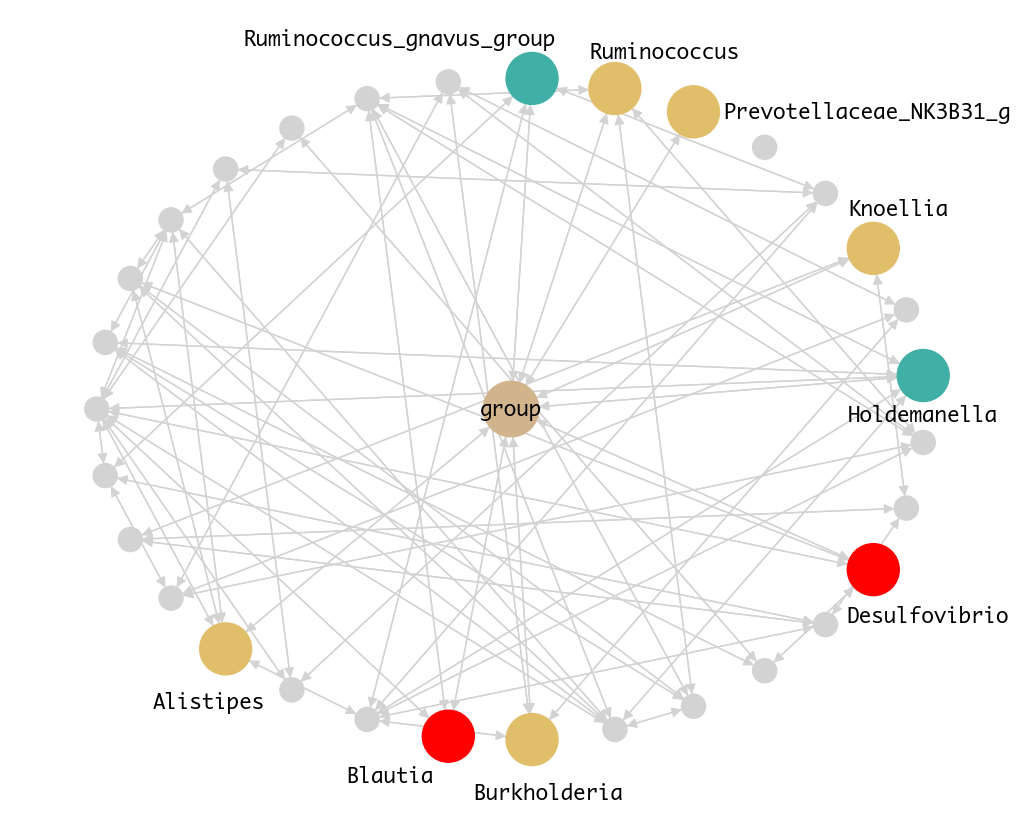

In [518]:
white_ = [0]
teal_ = [17, 24]
yellow_ = [5, 9, 19, 23, 22]
red_ = [8, 14]

G_2 = nx.from_numpy_array(np.array(adj_mat), create_using=nx.DiGraph)
all_nodes = list(G_2.nodes)


node_colors = ['lightgray'] * len(G_2.nodes)
node_sizes = [300] * len(G_2.nodes)

for idx in white_:
    node_colors[idx] = '#D2B48C'
    node_sizes[idx] = 1600

for idx in teal_:
    node_colors[idx] = '#40B0A6'
    node_sizes[idx] = 1400

for idx in yellow_:
    node_colors[idx] = '#E1BE6A'
    node_sizes[idx] = 1400

for idx in red_:
    node_colors[idx] = 'red'
    node_sizes[idx] = 1400


shell_layout = [[0]]
other_nodes = [n for n in range(1, len(G_2.nodes))]
shell_layout.append(other_nodes)


plt.figure(figsize=(10, 8))
pos_2 = nx.shell_layout(G_2, nlist=shell_layout)

nx.draw(G_2, pos_2, with_labels=False, node_color=node_colors, node_size=node_sizes, edge_color='lightgray', arrows=True, arrowsize=15)

labels = {}
for idx in white_:
    labels[idx] = proxy_labels[idx]
for idx in teal_:
    labels[idx] = proxy_labels[idx]
for idx in yellow_:
    labels[idx] = proxy_labels[idx]
for idx in red_:
    labels[idx] = proxy_labels[idx]

label_pos = pos_2.copy()
label_pos[yellow_[0]] = (label_pos[yellow_[0]][0] -0.02, label_pos[yellow_[0]][1] - 0.08)
label_pos[yellow_[1]] = (label_pos[yellow_[1]][0] + 0.02, label_pos[yellow_[1]][1] - 0.08)
label_pos[yellow_[2]] = (label_pos[yellow_[2]][0] + 0.03, label_pos[yellow_[2]][1] + 0.06)
label_pos[yellow_[3]] = (label_pos[yellow_[3]][0] + 0.06, label_pos[yellow_[3]][1] + 0.055)
label_pos[yellow_[4]] = (label_pos[yellow_[4]][0] + 0.24, label_pos[yellow_[4]][1])


label_pos[red_[0]] = (label_pos[red_[0]][0] -0.07, label_pos[red_[0]][1] - 0.06)
label_pos[red_[1]] = (label_pos[red_[1]][0] +0.065, label_pos[red_[1]][1] - 0.07)
label_pos[teal_[0]] = (label_pos[teal_[0]][0], label_pos[teal_[0]][1] - 0.06)
label_pos[teal_[1]] = (label_pos[teal_[1]][0]-0.16, label_pos[teal_[1]][1] + 0.06)


nx.draw_networkx_labels(G_2, label_pos, labels=labels, font_color='black', font_family="monaco", font_size=15)

plt.axis('off')
plt.show()